# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.optim import AdamW
import torch
from tqdm.auto import tqdm
import re


import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
nltk.download('wordnet')
nltk.download('stopwords')


import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data loading and preprocessing

In [2]:
# Загрузка данных
train_df = pd.read_csv('/kaggle/input/dsaa-6100-movie-review-sentiment-classification/movie_reviews/movie_reviews.csv')
test_df = pd.read_csv('/kaggle/input/dsaa-6100-movie-review-sentiment-classification/test_data.csv')

# Вывод первых 5 примеров
print("📊 Примеры данных из train_df:")
print(train_df[['text', 'label']].head(5).to_string(index=False))
print("-" * 50)

📊 Примеры данных из train_df:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [4]:
# Function for cleaning and normalizing text
def preprocess_text(text):
    # Remove HTML tags
    text = re.sub(r'<br\s*/?>', ' ', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    # Convert to lowercase
    text = text.lower()
    
    # Tokenization
    tokens = text.split()
    
    # Stemming and lemmatization
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return ' '.join(tokens)

# Apply to train and test
train_df['cleaned_text'] = train_df['text'].apply(preprocess_text)
test_df['cleaned_text'] = test_df['text'].apply(preprocess_text)

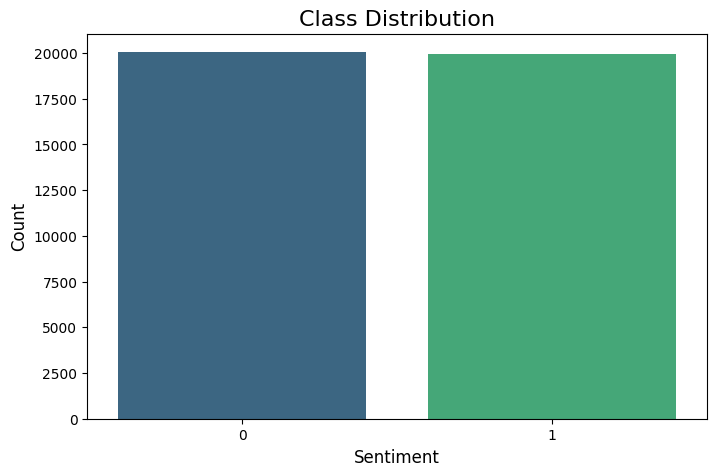

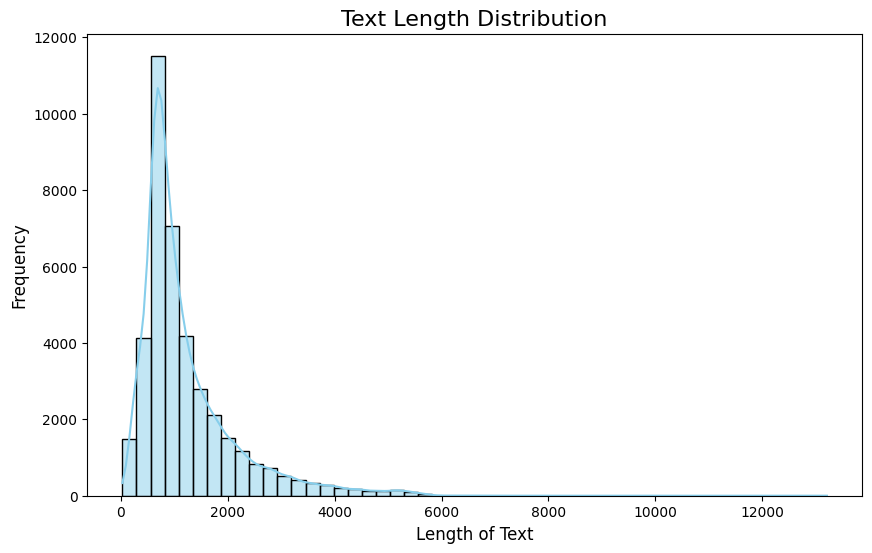

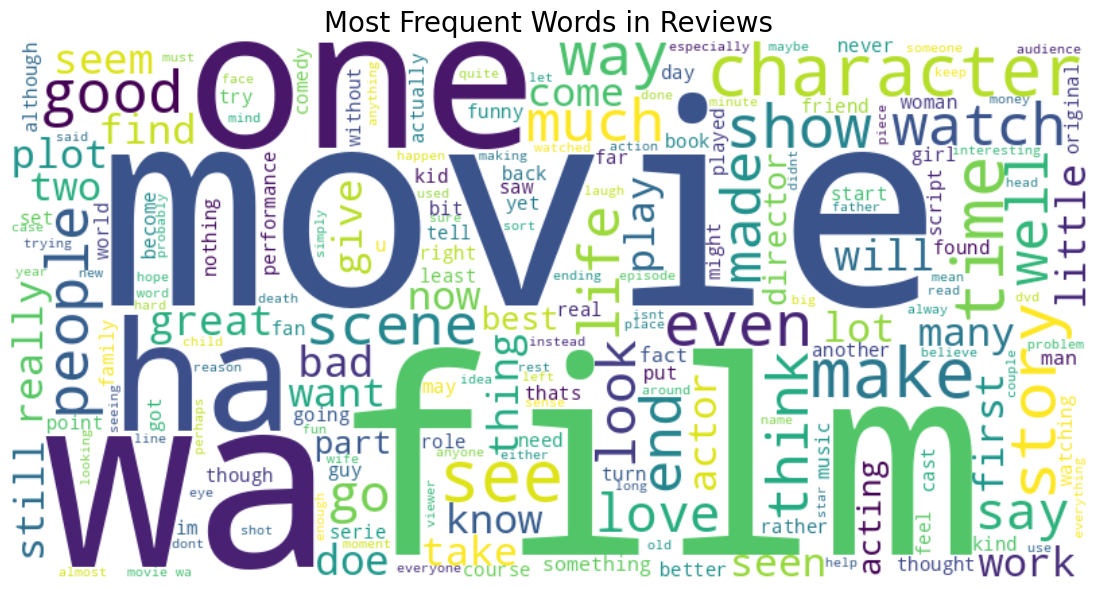

In [5]:
# --- Class Distribution ---
plt.figure(figsize=(8, 5))
sns.countplot(x='label', data=train_df, palette="viridis")
plt.title('Class Distribution', fontsize=16)
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.savefig('class_distribution.png')
plt.show()

# --- Text Length ---
train_df['text_length'] = train_df['cleaned_text'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(train_df['text_length'], bins=50, color='skyblue', kde=True)
plt.title('Text Length Distribution', fontsize=16)
plt.xlabel('Length of Text', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.savefig('text_length_distribution.png')
plt.show()

# --- Frequent Words: Word Cloud ---
def plot_word_cloud(text, title):
    wordcloud = WordCloud(width=800, height=400,
                          background_color='white',
                          colormap='viridis').generate(text)
    plt.figure(figsize=(15, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=20)
    plt.axis('off')
    plt.savefig(f'{title}.png')
    plt.show()

all_text = ' '.join(train_df['cleaned_text'])
plot_word_cloud(all_text, 'Most Frequent Words in Reviews')

# Train model

In [7]:
# Model setup
MODEL_NAME = "albert-base-v2"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

# Dataset class
class ReviewDataset(Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_len=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        output = {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }

        if self.labels is not None:
            output['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)

        return output

# Data splitting
X_train, X_val, y_train, y_val = train_test_split(
    train_df['cleaned_text'], train_df['label'],
    test_size=0.1, stratify=train_df['label'], random_state=42
)

# DataLoader
BATCH_SIZE = 16
MAX_LEN = 256

train_dataset = ReviewDataset(X_train.tolist(), y_train.tolist(), tokenizer, MAX_LEN)
val_dataset = ReviewDataset(X_val.tolist(), y_val.tolist(), tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Accuracy function
def calculate_accuracy(preds, targets):
    return (torch.argmax(preds, dim=1) == targets).float().mean().item()

# Training
NUM_EPOCHS = 3

for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0
    train_acc = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]", leave=False)

    for batch in progress_bar:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        preds = outputs.logits
        train_acc += calculate_accuracy(preds, labels)

        loss.backward()
        optimizer.step()

        progress_bar.set_postfix(loss=loss.item())

    avg_train_loss = total_loss / len(train_loader)
    avg_train_acc = train_acc / len(train_loader)

    # Validation
    model.eval()
    val_acc = 0
    val_progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Val]  ", leave=False)

    with torch.no_grad():
        for batch in val_progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            preds = outputs.logits
            val_acc += calculate_accuracy(preds, labels)

    avg_val_acc = val_acc / len(val_loader)

    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print(f"Train Loss: {avg_train_loss:.4f} | Train Accuracy: {avg_train_acc:.4f} | Val Accuracy: {avg_val_acc:.4f}")
    print("-" * 50)


Epoch 1/3
Train Loss: 0.3117 | Train Accuracy: 0.6589 | Val Accuracy: 0.59
--------------------------------------------------
Epoch 2/3
Train Loss: 0.2428 | Train Accuracy: 0.7735 | Val Accuracy: 0.6859
--------------------------------------------------
Epoch 3/3
Train Loss: 0.1003 | Train Accuracy: 0.8315 | Val Accuracy: 0.8091
--------------------------------------------------



# Submit

In [ ]:
# Prediction
test_dataset = ReviewDataset(test_df['cleaned_text'].tolist(), tokenizer=tokenizer, max_len=MAX_LEN)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

model.eval()
predictions = []
progress_bar_test = tqdm(test_loader, desc="Predicting Test Data")

with torch.no_grad():
    for batch in progress_bar_test:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
        predictions.extend(preds)

# Saving submission
submission = pd.DataFrame({
    'Id': test_df['Id'].astype(int),
    'Category': predictions
})
submission.to_csv('submission.csv', index=False)

print("Submission file created!")